# performance and exaplainability

In [ ]:
# install dependancies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [70]:
# read in data
overall_metrics = pd.read_parquet('../data/03_overall_metrics.parquet')
per_class_metrics = pd.read_parquet('../data/03_per_class_metrics.parquet')
confusion_matrix  = pd.read_parquet('../data/03_confusion_matrix.parquet')

## overall metrics

In [ ]:
# output overall metrics
styled_overall = (overall_metrics
    .style
    .background_gradient(subset=['value'], cmap='YlGnBu', vmin=0, vmax=1)  # Blue gradient with fixed 0-1 scale
    .bar(subset=['value'], color='#4a90e2', width=100, align='mid')  # Add bar charts with fixed width
    .format({'value': '{:.4f}'})  # Format to 4 decimal places
    .set_caption('Model Performance Metrics (0-1 scale)')
)

display(styled_overall)

,metric,value
0,accuracy,0.9031
1,precision_macro,0.8787
2,recall_macro,0.7954
3,f1_macro,0.8203
4,precision_weighted,0.9049
5,recall_weighted,0.9031
6,f1_weighted,0.9010
7,top3_accuracy,0.9737
8,top5_accuracy,0.9866


- Strong overall accuracy (~90%)
- Excellent top-k accuracy metrics (top-3 >97%, top-5 >98%)
- Notable gap between macro and weighted metrics
- Macro recall is the lowest metric (~80%)
- Performance suggests common categories classified more accurately than rare ones
- F1 metrics confirm class imbalance impact on model performance

In [13]:
# output per_class metrics
styled_class_metrics = (per_class_metrics.drop('class_id', axis=1)
   .style
   .background_gradient(subset=['precision', 'recall', 'f1_score', 'accuracy'], 
                        cmap='YlGnBu', vmin=0, vmax=1)  # Blue gradient with fixed 0-1 scale
   .background_gradient(subset=['support'], 
                        cmap='Oranges', vmin=0, vmax=per_class_metrics['support'].max())  # Orange gradient
   .bar(subset=['precision', 'recall', 'f1_score', 'accuracy'], 
        color='#4a90e2', width=100, align='mid')  # Add bar charts for metrics
   .bar(subset=['support'], 
        color='#ff9966', width=100, align='mid')  # Orange bars for support
   .format({'precision': '{:.4f}', 'recall': '{:.4f}', 
            'f1_score': '{:.4f}', 'accuracy': '{:.4f}'})  # Format metrics
   .set_caption('Per-Class Performance Metrics')
)

display(styled_class_metrics)

,class_name,precision,recall,f1_score,support,accuracy
11,Fashion,0.9573,0.9774,0.9672,1284,0.9774
15,Home,0.8492,0.9239,0.8850,1012,0.9239
4,Automotive,0.9733,0.9806,0.9770,930,0.9806
25,Tools & Home Improvement,0.9492,0.9492,0.9492,649,0.9492
24,Sports & Outdoors,0.9516,0.9786,0.9649,562,0.9786
0,All Beauty,0.9404,0.9535,0.9469,430,0.9535
19,Office Products,0.9520,0.9452,0.9486,420,0.9452
26,Toys & Games,0.9767,0.9378,0.9569,402,0.9378
8,Cell Phones & Accessories,0.9406,0.9630,0.9516,378,0.9630
17,Industrial & Scientific,0.7774,0.7799,0.7786,318,0.7799


- Significant performance variation across categories, with some showing excellent metrics (>95%) while others struggle (<70%)
- Categories with larger support (sample size) generally perform better (Fashion, Automotive, Tools & Home Improvement)
- Several electronics-related categories underperform (All Electronics, Car Electronics, GPS & Navigation)
- Perfect recall (1.0) in niche categories like Digital Music and Portable Audio & Accessories
- Computers category shows low recall despite moderate support, suggesting frequent misclassification
- Software has perfect precision but poor recall, indicating high confidence when predicted but missed cases
- Home Audio & Theater shows notably weak performance across all metrics
- Industrial & Scientific category has balanced but mediocre metrics (~78%)

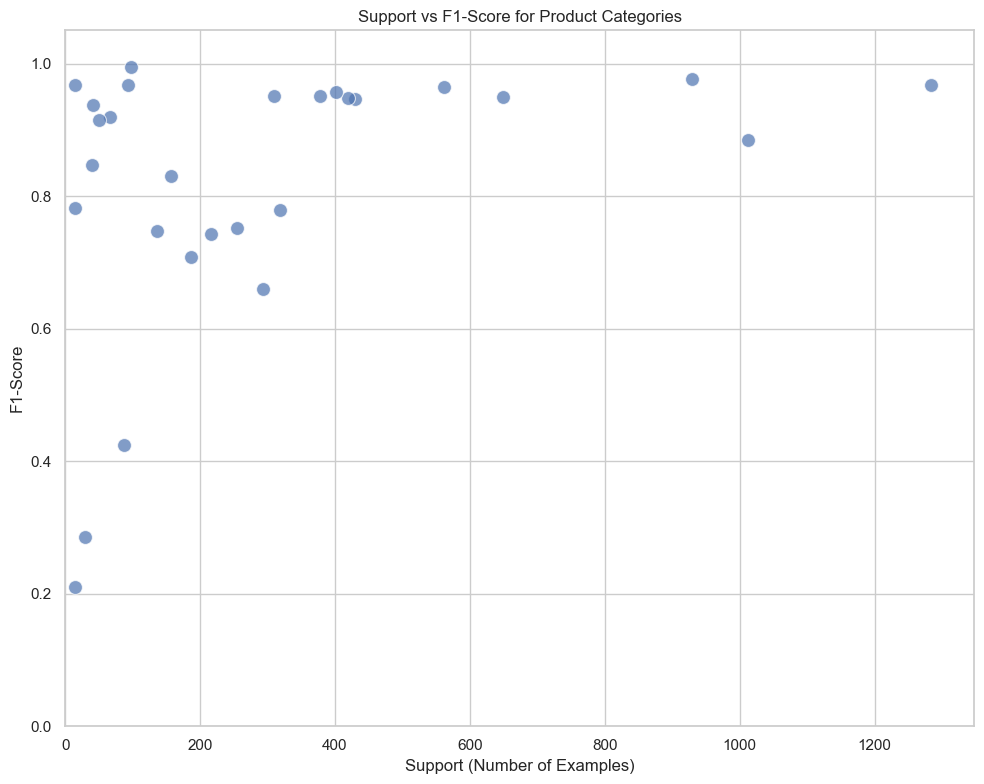

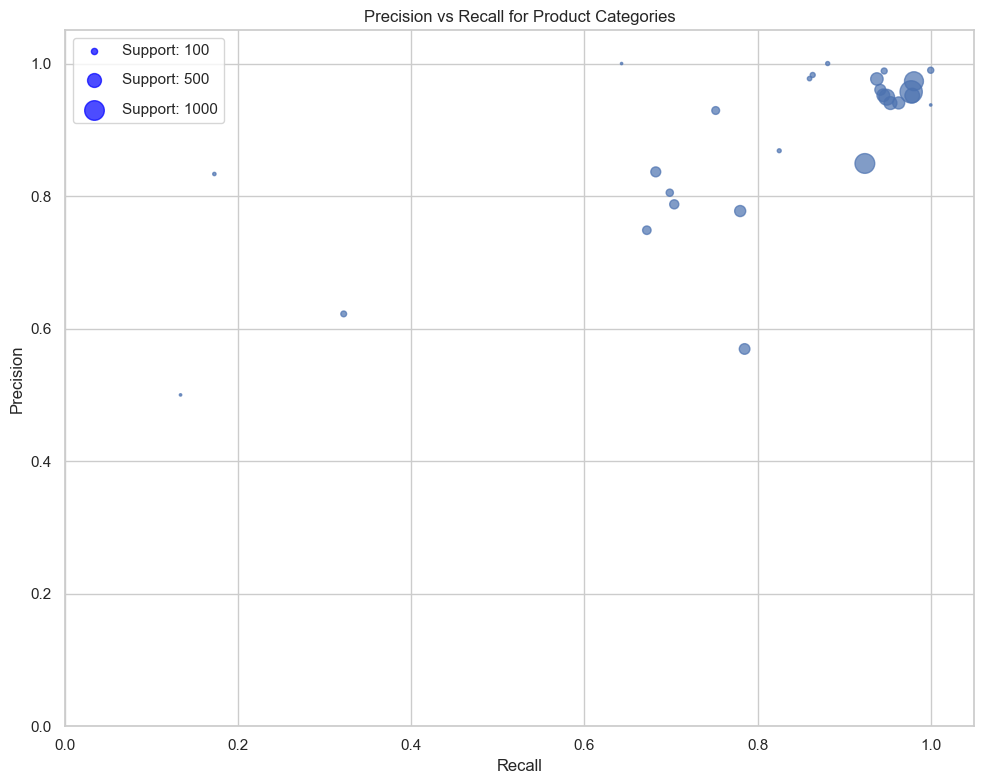

In [ ]:
# plot suppver vs f1
sns.set_theme(style="whitegrid")

# Create scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=per_class_metrics,
    x='support',
    y='f1_score',
    s=100,  # Point size
    alpha=0.7
)

plt.title('Support vs F1-Score for Product Categories')
plt.xlabel('Support (Number of Examples)')
plt.ylabel('F1-Score')
plt.xlim(0, None)  # Start x-axis at 0
plt.ylim(0, 1.05)  # Start y-axis at 0
plt.tight_layout()
plt.show()

# plot prescision vs recall
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    x=per_class_metrics['recall'],
    y=per_class_metrics['precision'],
    s=per_class_metrics['support']/5,  # Scale down the size for better visualization
    alpha=0.7
)

plt.title('Precision vs Recall for Product Categories')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0, 1.05)  # Start x-axis at 0
plt.ylim(0, 1.05)  # Start y-axis at 0

# Add legend for bubble sizes
sizes = [100, 500, 1000]
for size in sizes:
    plt.scatter([], [], s=size/5, alpha=0.7, color='blue', label=f'Support: {size}')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1)

plt.tight_layout()
plt.show()

support vs f1 relationship:
- There's a minimum viability threshold of examples needed (~200-300) before performance stabilizes
- The relationship suggests diminishing returns - adding more data to already well-performing categories likely won't yield significant improvements
- Some categories struggle despite having sufficient data, suggesting inherent classification difficulty rather than data scarcity
- The few extremely poorly performing categories (F1<0.3) likely have fundamental issues with feature representation or categorical confusion
- Categories with high performance despite low support indicate distinctive features making them easier to classify
- Data augmentation efforts should prioritize the lowest-performing categories with <300 examples
- The inconsistent mid-range performance suggests some categories might benefit from specialized feature engineering

precision vs recall vs support relationship:
- Model trade-off tendencies favor precision over recall in most categories
- Several high-support categories achieve both high precision and recall, indicating robust feature representation
- The few categories with low precision/high recall may have overly broad decision boundaries, causing false positives
- Categories with high precision/low recall likely have overly strict decision boundaries, missing valid examples
- Larger support classes (bigger circles) generally cluster in the optimal upper-right quadrant, suggesting threshold tuning may be beneficial for smaller classes
- The model would benefit from threshold optimization for categories with imbalanced precision-recall metrics
- The scattered performance across categories with similar support sizes indicates inherent differences in category separability

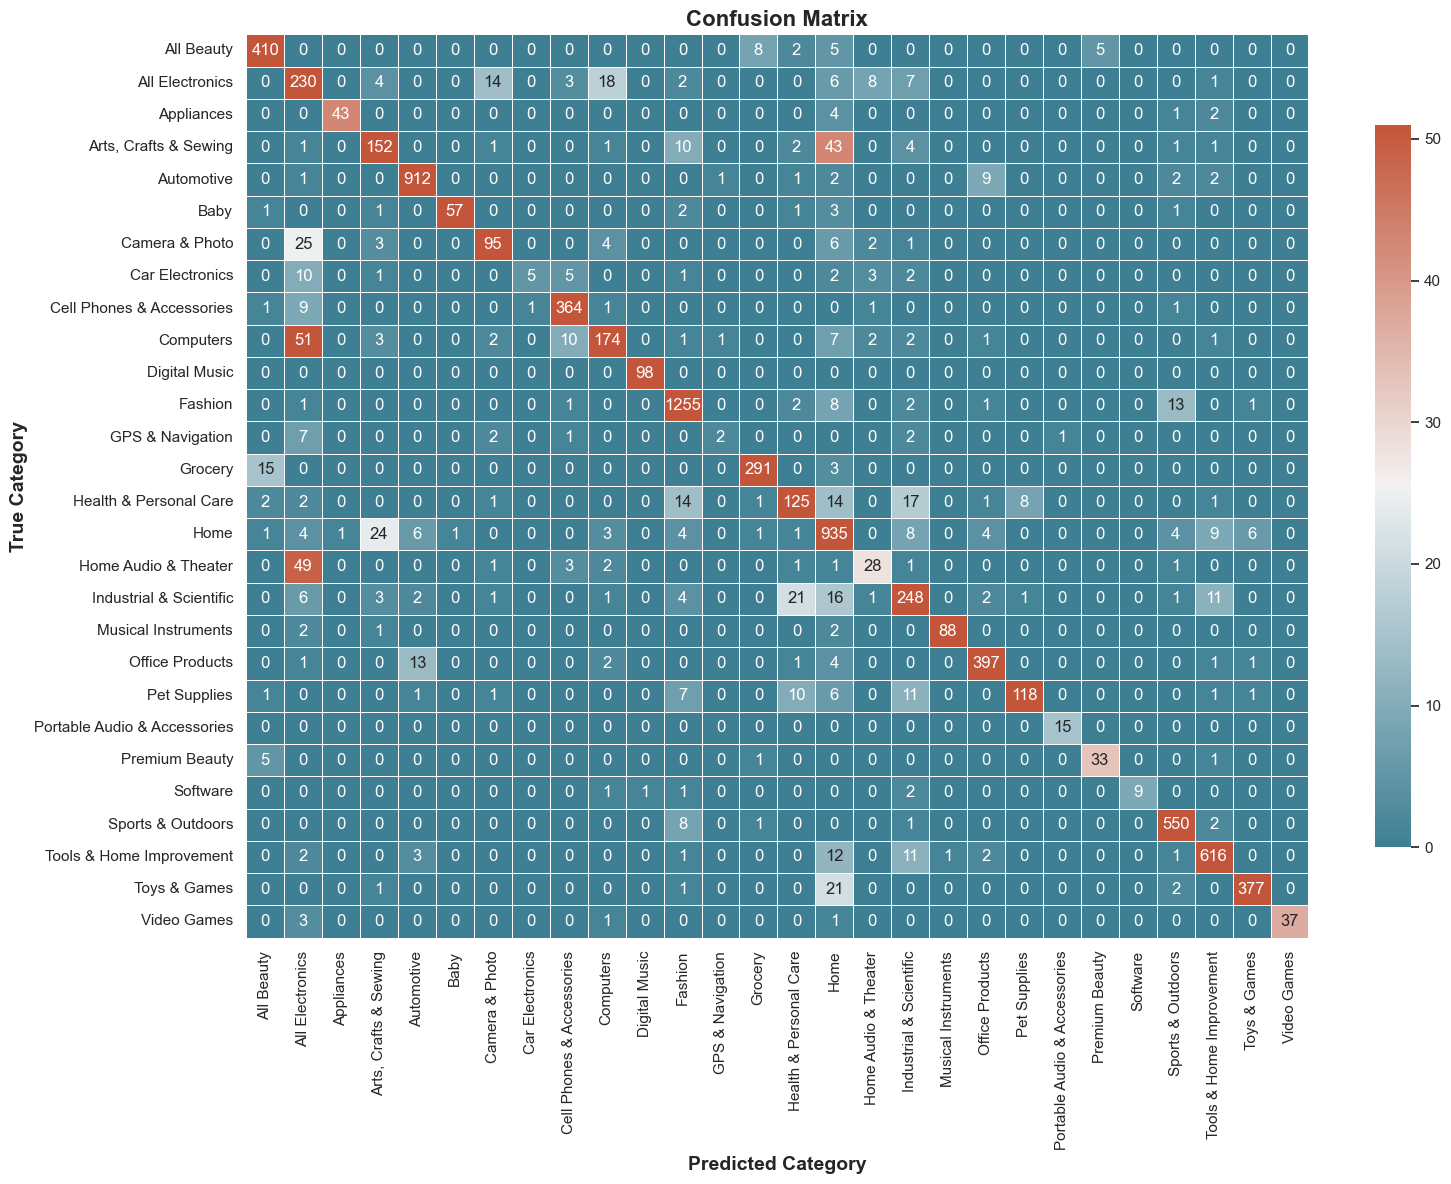

In [72]:
# Get max value excluding diagonal elements
mask = np.eye(confusion_matrix.shape[0], dtype=bool)
max_non_diag = confusion_matrix.mask(mask).max().max()

plt.figure(figsize=(16, 12))

# Create a custom colormap similar to the correlation matrix
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot the heatmap with labeled axes
ax = sns.heatmap(confusion_matrix, annot=True, cmap=cmap, fmt=".0f", 
            linewidths=.5, cbar_kws={"shrink": .8}, 
            vmax=max_non_diag)

# Add clear axis labels
plt.ylabel('True Category', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Category', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

- Strong diagonal dominance indicates generally good classification performance
- Electronics-related categories show significant cross-confusion (All Electronics, Home Audio & Theater, Car Electronics)
- Arts/Crafts/Sewing and Health/Personal Care have substantial misclassifications
- Digital Music and Portable Audio show nearly perfect separation
- Home category experiences confusion with several related categories (Tools, Furniture, Office)
- Industrial & Scientific items get misclassified into diverse categories
- Computers often mispredicted as All Electronics (~51 misclassifications)
- Fashion category shows remarkably clear separation despite its large sample size
- Several categories with sufficient samples still experience confusion with related categories
- Pet Supplies shows multiple small confusions across various unrelated categories

## explainabilty

In [ ]:
# read in data
global_importance = pd.read_parquet('../data/03_global_importance.parquet')
feature_importance = pd.read_parquet('../data/03_feature_importance.parquet')

#sample_explanations = pd.read_parquet('../data/03_sample_explanations.parquet')

## global feature improtance

In [59]:
# print features with the highest global impact
styled_global_importance = (global_importance[global_importance['importance'] >= 0.1]
    .style
    .background_gradient(subset=['importance'], cmap='YlGnBu', vmin=0, vmax=1)  # Blue gradient with fixed 0-1 scale
    .bar(subset=['importance'], color='#4a90e2', width=100, align='mid')  # Add bar charts with fixed width
    .format({'importance': '{:.4f}'})  # Format to 4 decimal places
    .set_caption('SHAP value feature importance where >= 0.1')
)

display(styled_global_importance)

,feature_name,importance
73,details_3,0.4591
52,details_10,0.2125
163,title_emb_2,0.2123
79,details_35,0.1778
74,details_30,0.1717
97,details_7,0.1515
66,details_23,0.1358
174,title_emb_3,0.1344
152,title_emb_1,0.1305
51,details_1,0.1269


- Structured data (details fields) dominate the top features, with details_3 having by far the highest importance (0.46)
- Title embeddings contribute significantly with 3 components in the top 10 features
- The model heavily relies on a mix of product details and title semantics
- Feature embeddings appear less influential, with only one component in the top features
- The importance drops sharply after the top feature, then gradually decreases
- The reliance on multiple embedding components suggests the model captures semantic patterns rather than simple keywords
- The high importance of specific details fields indicates certain product attributes strongly correlate with categories

In [67]:
# sum contribution by original column type
rolled_df = global_importance.copy()

rolled_df['prefix'] = rolled_df['feature_name'].str.split('_').str[0]

# For features with prefix_emb pattern
mask = rolled_df['feature_name'].str.contains('_emb')
rolled_df.loc[mask, 'prefix'] = rolled_df.loc[mask, 'feature_name'].str.split('_emb').str[0] + '_emb'

# Sum importances by prefix
rolled_df = rolled_df.groupby('prefix')['importance'].sum().reset_index()
rolled_df = rolled_df.rename(columns={'prefix': 'feature_group', 'importance': 'total_importance'})

# Sort by importance
rolled_df = rolled_df.sort_values('total_importance', ascending=False)

# style data frame
styled_rolled_df = (rolled_df
    .style
    .background_gradient(subset=['total_importance'], cmap='YlGnBu', vmin=0, vmax=1)  # Blue gradient with fixed 0-1 scale
    .bar(subset=['total_importance'], color='#4a90e2', width=100, align='mid')  # Add bar charts with fixed width
    .format({'total_importance': '{:.4f}'})  # Format to 4 decimal places
    .set_caption('SHAP value original feature importance')
)

display(styled_rolled_df)

,feature_group,total_importance
1,details,3.3565
4,title_emb,2.3123
2,features_emb,1.1652
0,desc_emb,0.8459
3,price,0.0341


- Details fields collectively have the highest impact, confirming structured attributes are the strongest predictors
- Title embeddings rank second, showing product names contain significant classification signals
- Features embeddings contribute meaningfully but with lower importance
- Description embeddings provide moderate value
- Price has minimal impact, suggesting category is primarily determined by product attributes rather than cost

## conclusions

**Strengths**

- Strong overall accuracy (~90%) with excellent top-k metrics (>97% for top-3)
- Several categories achieve near-perfect classification (Fashion, Digital Music)
- Structured product attributes (details fields) provide powerful predictive signals
- Title embeddings effectively capture product category information
- Model performs well even for some categories with limited samples

**Weaknesses**

- Significant cross-confusion between electronics-related categories
- Several low-support categories show extremely poor performance (F1 < 0.3)
- Imbalanced precision-recall trade-offs in some categories
- Price provides minimal predictive value despite being a key product attribute
- Performance inconsistency across categories with similar support sizes

**Key Takeaways**

- Product attributes and semantic content are more deterministic of category than price
- A minimum threshold of examples (~200-300) appears necessary for stable performance
- Electronics subcategories would benefit from more refined feature boundaries
- The model captures semantic patterns rather than simple keywords
- Confusion patterns largely follow intuitive category relationships

**Next Steps**

- Optimize classification thresholds for categories with imbalanced precision-recall
- Enhance feature engineering for frequently confused categories
- Consider hierarchical classification for related category groups
- Augment data for poorly-performing low-support categories
- Investigate performance on new products and category drift over time